In [1]:
!pip install guppy3

     |████████████████████████████████| 614kB 5.6MB/s 


## Import modules

In [56]:
import numpy as np
import itertools

# to get and read data
import os
from zipfile import ZipFile
from scipy.io import arff

# to plot the data
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# for neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [57]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/project")
from common_modules import data_f, network_f, patches_f, clusters_f
from char_modules import preprocess_f, plotting_f

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
import importlib
importlib.reload(plotting_f)

<module 'char_modules.plotting_f' from '/content/drive/MyDrive/project/char_modules/plotting_f.py'>

## get and read data

get data

In [5]:
if not os.path.exists('CharacterTrajectories'):
  # download zip
  data_f.download_file(url = 'http://www.timeseriesclassification.com/Downloads/CharacterTrajectories.zip',
                        saveAs = 'CharacterTrajectories.zip')
  # extract all the contents of zip file in current directory
  with ZipFile('CharacterTrajectories.zip', 'r') as zipObj:
    zipObj.extractall('CharacterTrajectories')
  print('folder extracted from zip')

else:
    print("folder exists")

folder exists


read data

In [6]:
# ignoring metadata at index 1, arff -> (data,meta)
train_data, train_meta = arff.loadarff('CharacterTrajectories/CharacterTrajectories_TRAIN.arff')
test_data, test_meta = arff.loadarff('CharacterTrajectories/CharacterTrajectories_TEST.arff')

train_data = preprocess_f.remove_nan(train_data)
test_data = preprocess_f.remove_nan(test_data)

# subtract 1 to start indexing from 0
train_data = [[input, label - 1] for input,label in train_data]
test_data = [[input, label - 1] for input,label in test_data]

max length = 182


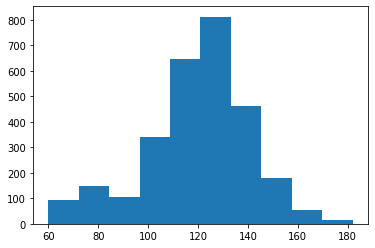

In [7]:
# distribution of sample lenghts
lengths = []

for sample in itertools.chain(train_data,test_data):
  input = sample[0][0]
  input = np.array(input)
  lengths.append(len(input))

print('max length =',np.max(lengths))
_ = plt.hist(lengths)

In [8]:
classes = ['a','b','c','d','e','g','h','l','m','n','o','p','q','r','s','u','v','w','y','z']
print('number of classes :',len(classes))

print('\ntrain data contains',len(train_data),'samples')
print('test data contains',len(test_data),'samples')

print('\neach sample has 3 channels : x,y and force')

number of classes : 20

train data contains 1422 samples
test data contains 1436 samples

each sample has 3 channels : x,y and force


## patches

In [9]:
kwargs = {'window_size':20, 'stride':10, 'resizeTo':100, 'medianFilter':True, 'gaussianFilter':True, 'normalize':(-1,1)}

kwargs['data'] = train_data
train_inputs, train_labels, train_indexes = patches_f.dataToPatches(**kwargs)
kwargs['data'] = test_data
test_inputs, test_labels, test_indexes = patches_f.dataToPatches(**kwargs)

create dataset and dataloader

In [ ]:
train_loader, val_loader, test_loader = data_f.createLoaders(train_inputs, train_labels,
                                                                  test_inputs, test_labels,
                                                                  batch_size=32)

### visualize patches

a
original sample


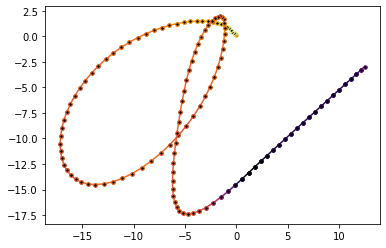

11 patches


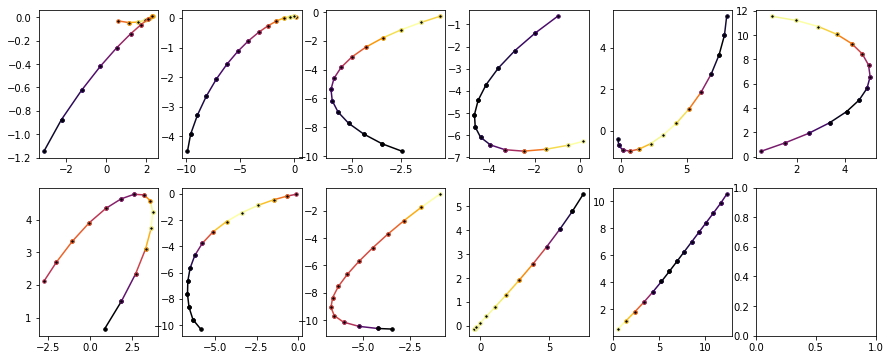

In [ ]:
plotting_f.plotChar(train_data, train_indexes, train_inputs, char='a')

## clustering

In [11]:
# flatten inputs to 2d array
nsamples, nx, ny = train_inputs.shape
sample_shape = nx, ny
train_inputs2d = train_inputs.reshape((nsamples,nx*ny))

plot silhoutte index for number of cluster 2 to 21

/usr/local/lib/python3.6/dist-packages/torch/distributed/distributed_c10d.py:126: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "



runtime:  332.764995098114

memory consumption:
Partition of a set of 1803484 objects. Total size = 235833514 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0    771   0 97171305  41  97171305  41 numpy.ndarray
     1 1029257  57 32936224  14 130107529  55 numpy.float64
     2 205550  11 30269131  13 160376660  68 str
     3 202330  11 16275480   7 176652140  75 tuple
     4  24446   1 10649728   5 187301868  79 list
     5  85489   5  6898932   3 194200800  82 bytes
     6  43579   2  6306744   3 200507544  85 types.CodeType
     7  41386   2  5628496   2 206136040  87 function
     8  13121   1  4845880   2 210981920  89 dict (no owner)
     9   4840   0  4801456   2 215783376  91 type
<1825 more rows. Type e.g. '_.more' to view.>



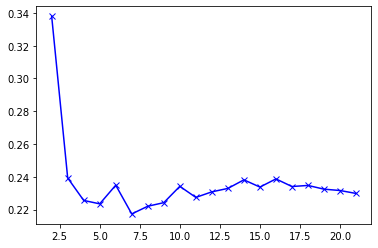

 n_clusters  silhouette       cal_har  dav_bould  adj_rand  adj_mut_inf  v_measure  fowlk_mall
          2    0.337961  10165.967567   1.161526  0.005735     0.021568   0.021908    0.173529
          3    0.239260   7578.097541   1.597998  0.014135     0.040724   0.041323    0.152688
          4    0.225542   5996.264646   1.758425  0.019516     0.057472   0.058298    0.139880
          5    0.223452   5255.831496   1.708785  0.021039     0.061615   0.062663    0.130473
          6    0.234843   4690.758231   1.654746  0.021335     0.075713   0.076965    0.124700
          7    0.217311   4345.231916   1.783188  0.036577     0.106098   0.107489    0.126916
          8    0.221998   4046.675821   1.752430  0.041164     0.116653   0.118215    0.124985
          9    0.224184   3811.474887   1.660056  0.035525     0.114306   0.116054    0.113660
         10    0.234151   3642.008607   1.662220  0.043259     0.137732   0.139609    0.116855
         11    0.227385   3487.563575   1.634054  

In [12]:
_ = clusters_f.form_clusters(train_inputs2d, "KMeans", list(range(2,22)), train_labels)


runtime:  1393.6904788017273

memory consumption:
Partition of a set of 1799779 objects. Total size = 235936909 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0    335   0 97647137  41  97647137  41 numpy.ndarray
     1 1029166  57 32933312  14 130580449  55 numpy.float64
     2 205845  11 30415174  13 160995623  68 str
     3 202159  11 16273488   7 177269111  75 tuple
     4  24166   1 10626144   5 187895255  80 list
     5  85644   5  6917116   3 194812371  83 bytes
     6  43653   2  6317400   3 201129771  85 types.CodeType
     7  41014   2  5577904   2 206707675  88 function
     8   4846   0  4808248   2 211515923  90 type
     9  12663   1  4743456   2 216259379  92 dict (no owner)
<1742 more rows. Type e.g. '_.more' to view.>



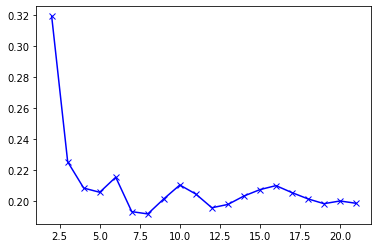

 n_clusters  silhouette      cal_har  dav_bould  adj_rand  adj_mut_inf  v_measure  fowlk_mall
          2    0.319088  8656.833712   1.148625  0.002098     0.015997   0.016344    0.176136
          3    0.225199  7141.074361   1.636874  0.013244     0.038360   0.038959    0.150416
          4    0.208257  5595.733652   1.784687  0.018668     0.061833   0.062655    0.139172
          5    0.205548  4920.632198   1.809661  0.021248     0.068715   0.069754    0.130674
          6    0.215266  4338.500386   1.699995  0.020287     0.079425   0.080677    0.125235
          7    0.193056  3973.847711   1.873545  0.036080     0.113227   0.114611    0.127979
          8    0.191590  3689.510345   1.803234  0.040699     0.117746   0.119311    0.125646
          9    0.201300  3439.004662   1.723907  0.037140     0.127134   0.128870    0.118185
         10    0.210239  3259.264376   1.637300  0.040561     0.144596   0.146482    0.118698
         11    0.204393  3112.260588   1.627961  0.042564   

In [13]:
_ = clusters_f.form_clusters(train_inputs2d, "AgglomerativeClustering", list(range(2,22)), train_labels)


runtime:  562.4049112796783

memory consumption:
Partition of a set of 1804413 objects. Total size = 379669401 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0    344   0 240188801  63 240188801  63 numpy.ndarray
     1 1029131  57 32932192   9 273120993  72 numpy.float64
     2 206877  11 30516003   8 303636996  80 str
     3 202260  11 16280536   4 319917532  84 tuple
     4  24728   1 10714848   3 330632380  87 list
     5  85816   5  6930527   2 337562907  89 bytes
     6  43654   2  6317544   2 343880451  91 types.CodeType
     7  41027   2  5579672   1 349460123  92 function
     8  14160   1  5482328   1 354942451  93 dict (no owner)
     9   4846   0  4810096   1 359752547  95 type
<1745 more rows. Type e.g. '_.more' to view.>



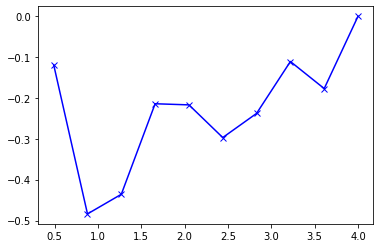

  eps  n_clusters  silhouette     cal_har  dav_bould  adj_rand  adj_mut_inf  v_measure  fowlk_mall
 0.49           4   -0.118989    5.060523   1.059919 -0.000007     0.000520   0.001529    0.227330
 0.88          75   -0.483815   10.245343   1.105464 -0.000481     0.031155   0.056314    0.216209
 1.27         239   -0.435831   26.668928   1.187723  0.002795     0.166169   0.214942    0.168226
 1.66         226   -0.214430   86.618586   1.315024  0.020906     0.252753   0.286765    0.119927
 2.05         128   -0.217192  157.012021   1.497320  0.046311     0.237111   0.257346    0.122934
 2.44          42   -0.297073   93.167120   1.994160  0.014031     0.139947   0.149754    0.180623
 2.83          14   -0.238055  126.105669   2.721490  0.005360     0.078336   0.082372    0.202513
 3.22           4   -0.111163   51.920177   4.191306  0.001417     0.023890   0.025017    0.224745
 3.61           5   -0.177306    7.644262   2.852519  0.000165     0.004382   0.005787    0.226204
 4.00     

In [32]:
_ = clusters_f.form_clusters(train_inputs2d, "DBSCAN", np.linspace(0.49,4,10) , train_labels)


runtime:  1572.1637060642242

memory consumption:
Partition of a set of 1805818 objects. Total size = 333147057 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0    344   0 193340801  58 193340801  58 numpy.ndarray
     1 1029187  57 32933984  10 226274785  68 numpy.float64
     2 206982  11 30525056   9 256799841  77 str
     3 202284  11 16282248   5 273082089  82 tuple
     4  24924   1 10744464   3 283826553  85 list
     5  85872   5  6934450   2 290761003  87 bytes
     6  43654   2  6317544   2 297078547  89 types.CodeType
     7  14699   1  5688600   2 302767147  91 dict (no owner)
     8  41027   2  5579672   2 308346819  93 function
     9   4846   0  4810096   1 313156915  94 type
<1745 more rows. Type e.g. '_.more' to view.>



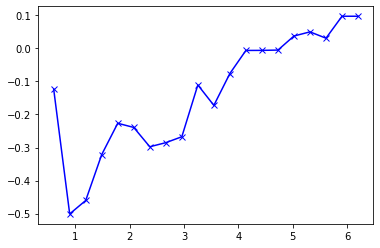

      eps  n_clusters  silhouette     cal_har  dav_bould  adj_rand  adj_mut_inf  v_measure  fowlk_mall
 0.600000          10   -0.122973    5.658404   1.092095 -0.000006     0.001957   0.005205    0.226694
 0.894737          80   -0.500888   10.868648   1.120658 -0.000548     0.035228   0.061859    0.214793
 1.189474         211   -0.460201   21.822641   1.152140  0.001499     0.144664   0.191867    0.180091
 1.484211         256   -0.321295   51.175527   1.238193  0.010946     0.221660   0.264259    0.137362
 1.778947         185   -0.226611  108.083745   1.349700  0.032942     0.243797   0.273145    0.121733
 2.073684         120   -0.239254  130.873307   1.505630  0.041034     0.227011   0.246753    0.127161
 2.368421          50   -0.297677   91.424559   1.913729  0.016994     0.169025   0.180187    0.175912
 2.663158          24   -0.285333   88.632967   2.245067  0.005429     0.099760   0.106435    0.194994
 2.957895          14   -0.267422  126.527382   2.596043  0.005039     0.

In [39]:
_ = clusters_f.form_clusters(train_inputs2d, "DBSCAN", np.linspace(0.6,6.2,20) , train_labels)

In [ ]:
_ = clusters_f.form_clusters(train_inputs2d, "OPTICS", list(range(5,21)), train_labels)

### visualize cluster centers


runtime:  10.078878402709961

memory consumption:
Partition of a set of 1822175 objects. Total size = 238961512 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0   1145   0 97049893  41  97049893  41 numpy.ndarray
     1 1029892  57 32956544  14 130006437  54 numpy.float64
     2 212052  12 30979706  13 160986143  67 str
     3 203271  11 16346688   7 177332831  74 tuple
     4  25961   1 10880328   5 188213159  79 list
     5  85934   5  6939475   3 195152634  82 bytes
     6  43655   2  6317688   3 201470322  84 types.CodeType
     7  16258   1  6158856   3 207629178  87 dict (no owner)
     8  41585   2  5655560   2 213284738  89 function
     9   4846   0  4810504   2 218095242  91 type
<1830 more rows. Type e.g. '_.more' to view.>

 n_clusters  silhouette       cal_har  dav_bould  adj_rand  adj_mut_inf  v_measure  fowlk_mall
          2    0.337961  10165.967567   1.161526  0.005735     0.021568   0.021908    0.173529

cluster centers visuali

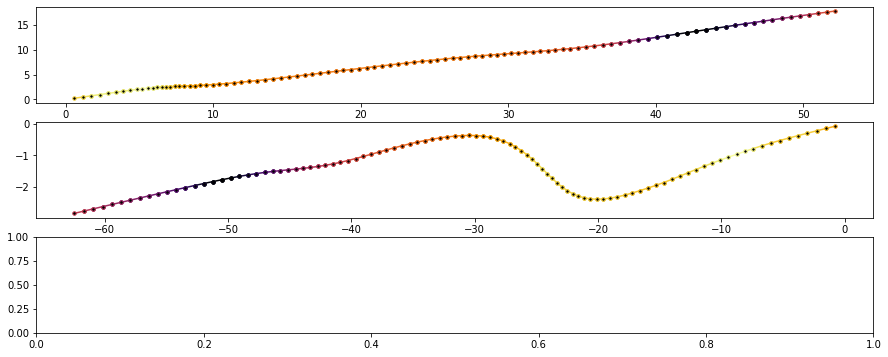

In [59]:
cluster_centers = clusters_f.form_clusters(train_inputs2d, "KMeans", [2], train_labels)

print("\ncluster centers visualized")
plotting_f.plotClusters(cluster_centers, sample_shape)

## neural network

### define network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 4 input channels, 6 output channels, row convolution kernel of size 3
        self.conv1 = nn.Conv1d(4, 6, 3)
        self.conv2 = nn.Conv1d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(368, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)

    def forward(self, x):
        # output given by : math.floor((inp-(k-1)-1)/s+1)
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### create network

In [ ]:
net = Net().to(device)

#Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### train network

epoch: 15, train loss: 1.687, val loss: 1.711
epoch: 30, train loss: 0.989, val loss: 1.076
epoch: 45, train loss: 0.790, val loss: 0.896
epoch: 60, train loss: 0.671, val loss: 0.843
epoch: 75, train loss: 0.598, val loss: 0.841
epoch: 90, train loss: 0.533, val loss: 0.828
epoch: 105, train loss: 0.486, val loss: 0.793
epoch: 120, train loss: 0.453, val loss: 0.909
epoch: 135, train loss: 0.414, val loss: 0.854
epoch: 150, train loss: 0.386, val loss: 0.861

Finished Training


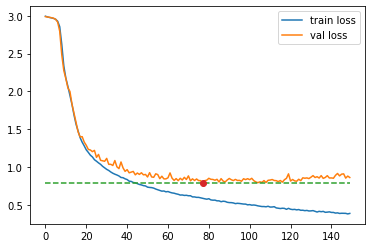

In [ ]:
best_params = network_f.trainNet(net,criterion,optimizer, 
                                  train_loader,val_loader,
                                  epochs=150)

In [ ]:
net.load_state_dict(best_params)

<All keys matched successfully>

### evaluate network

In [ ]:
print("evaluation results on train data")
network_f.evaluate(net,train_loader,classes)
print("evaluation results on test data")
network_f.evaluate(net,test_loader,classes)

evaluation results on train data



              precision    recall  f1-score   support

           a     0.7891    0.7632    0.7759       760
           b     0.6301    0.7929    0.7022       623
           c     0.9683    0.9735    0.9709       377
           d     0.9141    0.7800    0.8418       641
           e     0.9295    0.9606    0.9448       686
           g     0.7989    0.7080    0.7507       589
           h     0.6878    0.5872    0.6335       499
           l     0.9944    0.9781    0.9862       365
           m     0.8000    0.9231    0.8571       611
           n     0.7244    0.5380    0.6174       474
           o     0.9077    0.8817    0.8945       524
           p     0.6974    0.6926    0.6950       579
           q     0.9151    0.8744    0.8943       629
           r     0.7727    0.5690    0.6554       478
           s     0.7840    0.9193    0.8463       545
           u     0.6339    0.6736    0.6532       527
           v     0.9786    0.9786    0.9786       513
           w     0.5120   


              precision    recall  f1-score   support

           a     0.6966    0.6520    0.6736      1000
           b     0.5606    0.7090    0.6261       842
           c     0.9117    0.9473    0.9291       512
           d     0.8508    0.7585    0.8020       857
           e     0.8808    0.9033    0.8919       900
           g     0.6570    0.5500    0.5987       780
           h     0.5712    0.4954    0.5306       656
           l     0.9824    0.9084    0.9439       491
           m     0.7263    0.8005    0.7616       812
           n     0.5823    0.4175    0.4863       661
           o     0.8278    0.8588    0.8430       694
           p     0.6036    0.6130    0.6082       770
           q     0.8270    0.8369    0.8319       834
           r     0.6897    0.4791    0.5654       645
           s     0.7809    0.8776    0.8264       727
           u     0.5255    0.5755    0.5494       735
           v     0.9171    0.9345    0.9257       687
           w     0.4306   